In [1]:
import torch
import torch.utils.data
import torch.cuda
import torch.optim
import torch.nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
def imshow(imgs, label=""):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation="nearest")  # type: ignore
    ax[0][0].axis("off")  # type: ignore
    ax[0][0].set_title(label)  # type: ignore
    fig.show()  # type: ignore


def check_mem():
    return torch.cuda.memory_allocated() / 1024 / 1024 / 1024


In [3]:
from functools import lru_cache

datadir = Path('../../data')
patchesdir = Path('../Patches')
maindir = Path('..')

# imagenet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

sampler = torch.utils.data.RandomSampler

@lru_cache(maxsize=10)
def dataset(img_size, split="train"):
    return datasets.ImageNet(root=str(datadir), split=split, transform=transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
            to_tensor
        ]))

def subset(imageset, size):
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [4]:
from torchvision import models

ensemble = {
    'ResNet101'    : {"model": models.resnet101(pretrained=True), "img_size": 244},
    'VGG16'        : {"model": models.vgg16(pretrained=True), "img_size": 244},
    'VGG19_with_bn': {"model": models.vgg19_bn(pretrained=True), "img_size": 244},
    'GoogLeNet'    : {"model": models.googlenet(pretrained=True), "img_size": 244},
    'Inception_v3' : {"model": models.inception_v3(pretrained=True), "img_size": 299}
}

for model_dict in ensemble.values():
    model_dict["model"].eval()
    for param in model_dict["model"].parameters():
        param.requires_grad = False

ensemble = list(ensemble.items())

In [5]:
def epoch(model, dataloader, target, optimizer=None, train=True):
    assert optimizer is not None or not train
    torch.set_grad_enabled(train)
    
    model = model.to(device)

    scores = {"top1": 0, "top5": 0, "running_loss": 0.0}

    pbar = tqdm(dataloader, desc="Starting...", leave=False)
    for data, labels in pbar:
        # pbar.write(str(check_mem()))
        data = data.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()
            model.zero_grad()

        x = pm.random_patch_place(data)

        adv_out = model(x)
        _, preds = adv_out.topk(5)

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(adv_out, torch.tensor(data.size(0) * [target], device=device))

        if train:
            loss.backward()
            optimizer.step()

        scores["running_loss"] += loss.item() * data.size(0)

        for img_preds in preds:
            if target in img_preds:
                scores["top5"] += 1
                if target in img_preds[0]:
                    scores["top1"] += 1

        pbar.set_description(
            f"top1 - {scores['top1']}, top5 - {scores['top5']} of {(pbar.n+1) * data.size(0)}"
        )

    pbar.close()
    return scores


In [6]:
def train_patch(
    target,
    patchname="patch",
    savedir=None
):
    if savedir is not None and not Path.is_dir(Path(savedir)):
        Path.mkdir(Path(savedir))

    scores = defaultdict(lambda: {"train": [], "test": []})

    epbar = tqdm(range(n_epochs), leave=True)
    for i_epoch in epbar:
        try:
            if i_epoch in lr_change:
                lr = lr_change[i_epoch]

            np.random.shuffle(ensemble)
            epbar.set_description(f"Epoch {i_epoch+1}, lr={lr:.2f}")

            # training
            epoch_scores = defaultdict(float)
            pbar = tqdm(ensemble, leave=False)
            for modelname, model_dict in pbar:
                pbar.set_description(f"training {modelname}")

                optimizer = torch.optim.SGD([pm.patch], lr=lr, momentum=momentum)
                dl = dataloader(subset(dataset(model_dict["img_size"], "train"), train_size), batch_size)

                model_scores = epoch(model_dict["model"], dl, target, optimizer)
                for score, value in model_scores.items():
                    epoch_scores[score] += value

            for score, value in epoch_scores.items():
                scores[score]["train"].append(value / (train_size * len(ensemble)))

            pbar.close()

            # testing
            epoch_scores = defaultdict(float)
            pbar = tqdm(ensemble, leave=False)
            for modelname, model in pbar:
                pbar.set_description(f"testing {modelname}")

                dl = dataloader(subset(dataset(model_dict["img_size"], "val"), test_size), batch_size)
                model_scores = epoch(model_dict["model"], dl, target, train=False)

                for score, value in model_scores.items():
                    epoch_scores[score] += value

            for score, value in epoch_scores.items():
                scores[score]["test"].append(value / (test_size * len(ensemble)))

            pbar.close()

            if savedir is not None:
                pm.pil_patch.save(Path(savedir) / f"{patchname}_ep_{i_epoch}.png")
        except KeyboardInterrupt:
            break
    epbar.close()
    return scores



In [9]:
from patch_maker import PatchMaker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pm = PatchMaker(mean, std, device=device)
patch_size = 140
batch_size = 10

train_size = 200 
test_size  = 100
n_epochs = 30
patch = to_tensor(Image.open('../cian.jpg'))

lr = 1
lr_change = { 0: 1, 10: 0.1, 20: 0.01 }
momentum = 0.9

pm.set_patch(patch, patch_size)
# pm.random_init_patch(patch_size)
pm.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.3))


In [10]:
patchname = "937_broccoli"
patchdir = Path("../Patches") / patchname


scores = train_patch(937, patchname, patchdir)

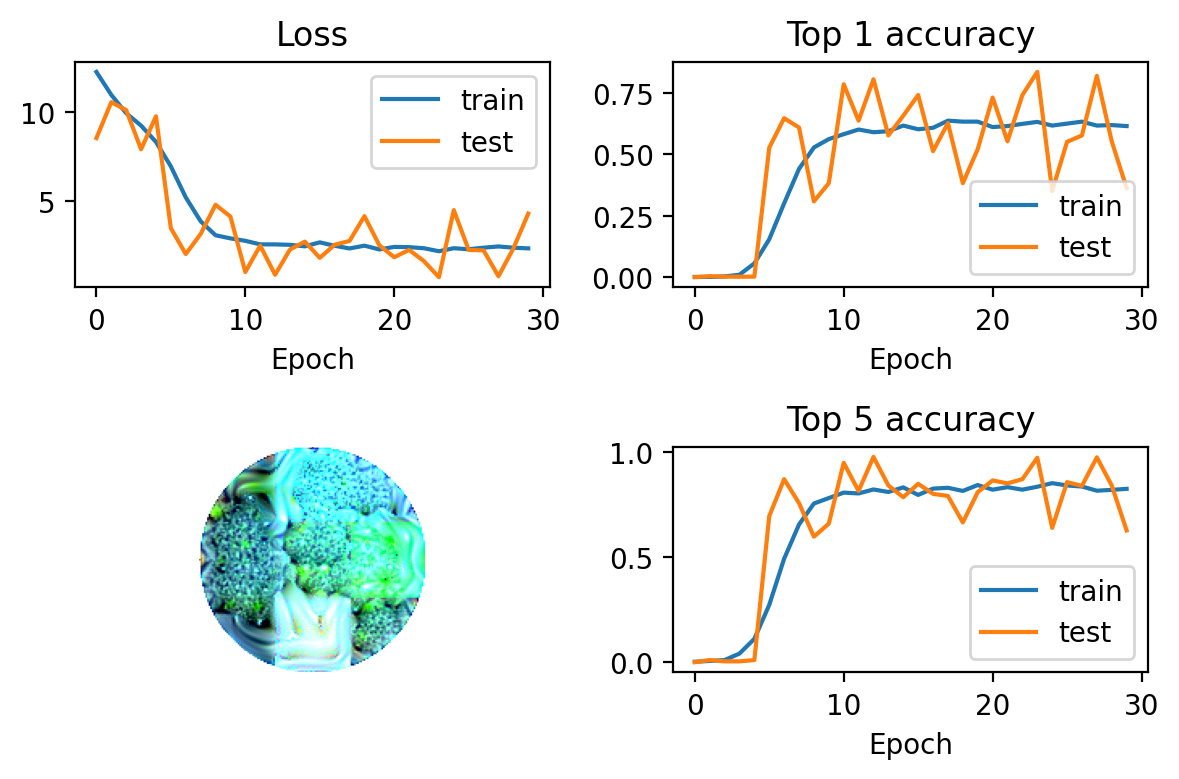

In [11]:
fig, ax = plt.subplots(2,2, squeeze=False, dpi=200)
for phase, ls in scores["running_loss"].items():
    ax[0][0].plot(ls, label=phase)
ax[0][0].legend()
ax[0][0].set_title('Loss')
ax[0][0].set_xlabel('Epoch')
ax[1][0].axis('off')
ax[1][0].imshow(pm.pil_patch)
for phase, ls in scores['top1'].items():
    ax[0][1].plot(ls, label=phase)
ax[0][1].legend()
ax[0][1].set_title('Top 1 accuracy')
ax[0][1].set_xlabel('Epoch')
for phase, ls in scores['top5'].items():
    ax[1][1].plot(ls, label=phase)
ax[1][1].legend()
ax[1][1].set_title('Top 5 accuracy')
ax[1][1].set_xlabel('Epoch')
fig.tight_layout()

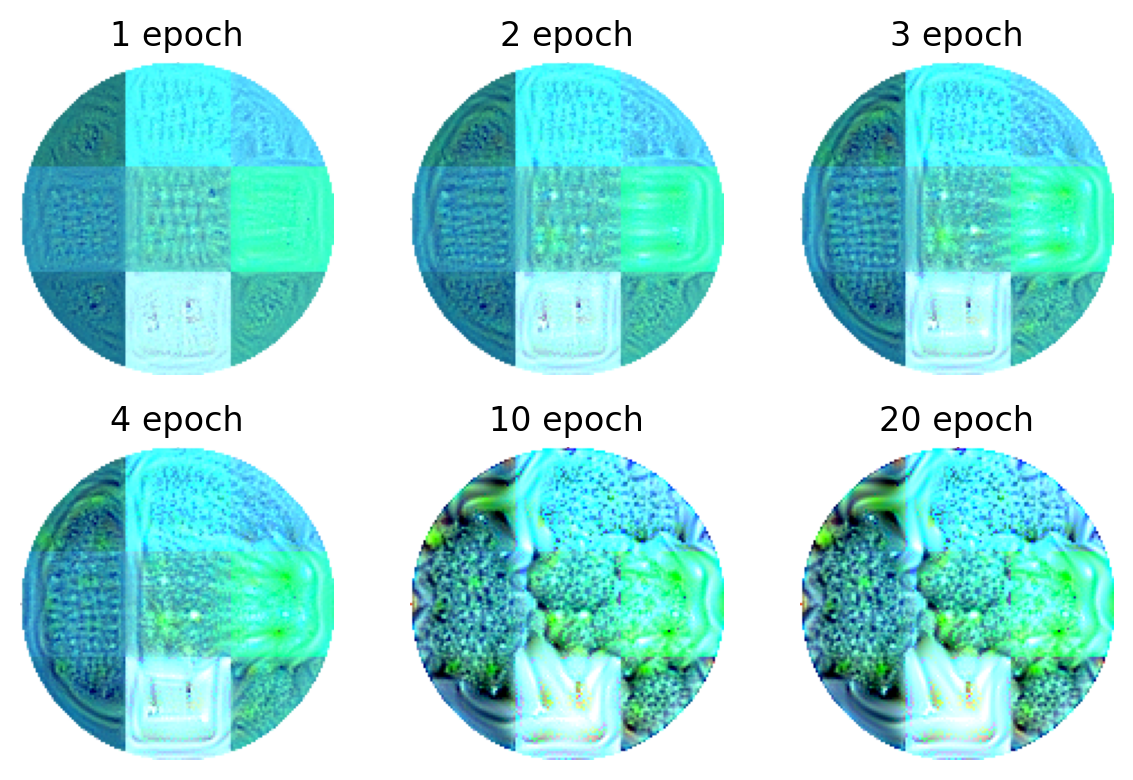

In [12]:
def epoch_patch(i):
    return Image.open(patchdir/f"{patchname}_ep_{i}.png")

fig, ax = plt.subplots(2,3, squeeze=False, dpi=200)
pis = [1, 2, 3, 4, 10, 20]
cur_i = 0
for a in ax:
    for x in a:
        x.axis('off')
        x.set_title(f'{pis[cur_i]} epoch')
        x.imshow(epoch_patch(pis[cur_i]-1))
        cur_i += 1
        
# ax[0,0].set_title('Init picture')
# ax[0,0].imshow(init)

fig.tight_layout()

In [22]:
trainset.classes.index(('bee',),)

309

In [117]:
pm_test = PatchMaker(mean, std, device=device)

patch = Image.open(patchdir/f"{patchname}_ep_19.png")
pm_test.set_patch(to_tensor(patch))
pm_test.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.1))
modelname, model = ensemble[2]
model = model.to(device)
modelname

'Inception_v3'

In [15]:
it = iter(dataloader(trainset, 1))

'mantis'

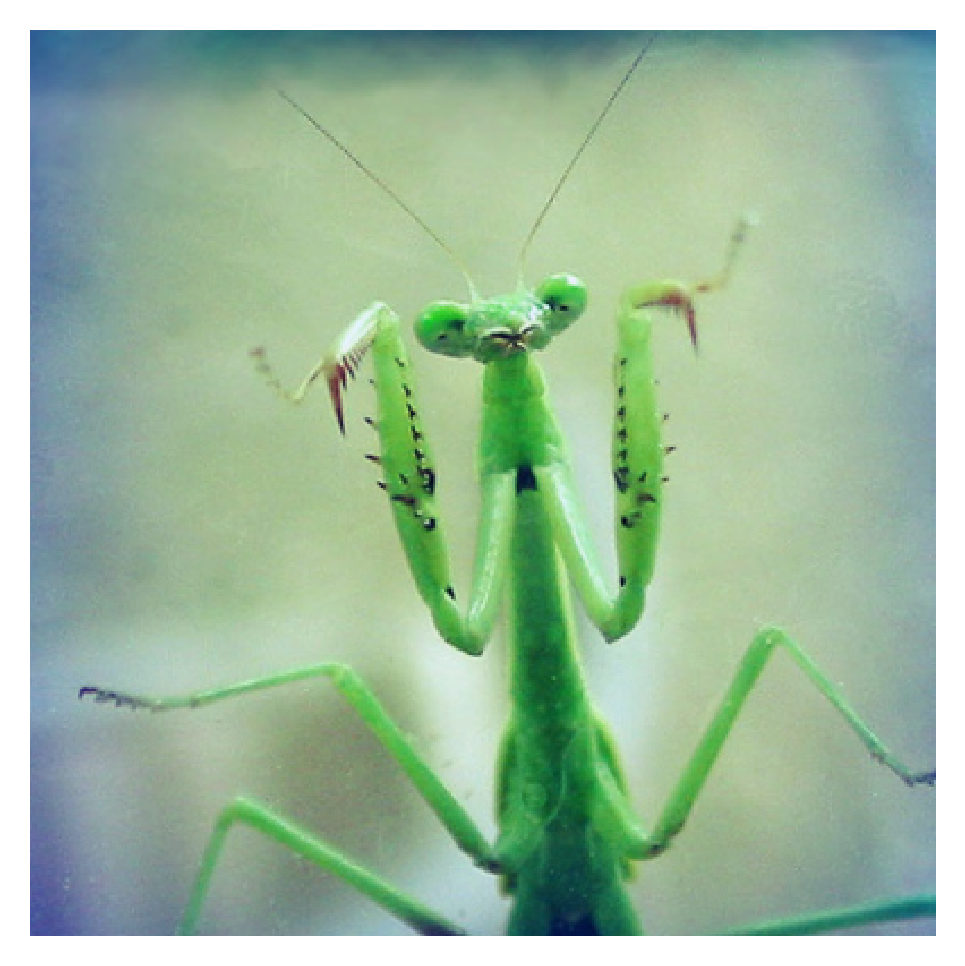

In [178]:
image, gt = next(it)
imshow(image)
trainset.classes[gt.item()][0]

In [184]:
with torch.no_grad():
    data = image.to(device)
    out = model(data)
    _, init_preds = out.topk(5)
    
    x = pm_test.random_patch_place(data)
    
    adv_out = model(x)
    _, preds = adv_out.topk(5)
    

[trainset.classes[i.item()][0] for i in preds.squeeze()]

['bee', 'mantis', 'apiary', 'fly', 'honeycomb']

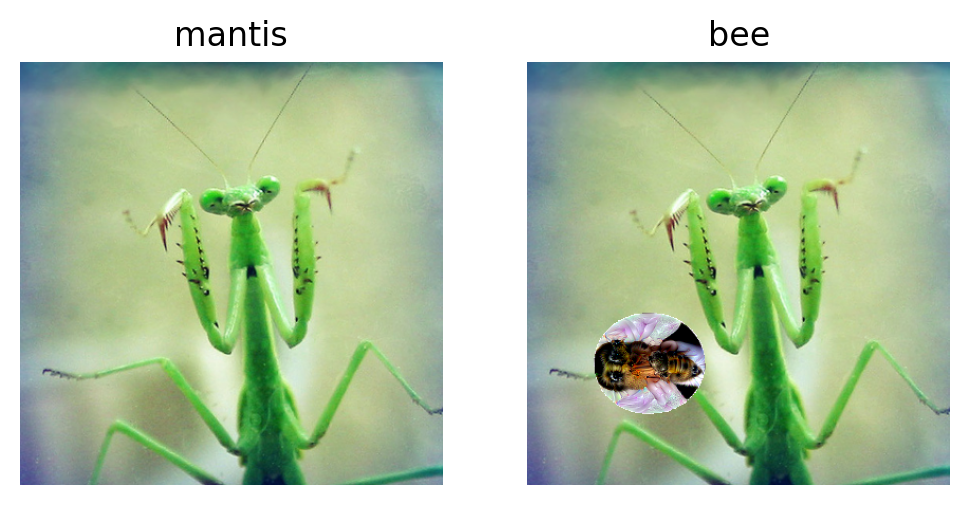

In [185]:
fig, ax = plt.subplots(1,2, squeeze=False, dpi=200)
ax[0,0].axis('off')
ax[0,0].set_title(trainset.classes[init_preds.squeeze()[0].item()][0])
ax[0,0].imshow(to_pil(data.cpu().detach().squeeze()))
ax[0,1].axis('off')
ax[0,1].set_title(trainset.classes[preds.squeeze()[0].item()][0])
ax[0,1].imshow(to_pil(x.cpu().detach().squeeze()))

In [8]:
dataset(244, "train").class_to_idx['broccoli']

937

In [17]:
dataset(244, "train").classes

[('tench', 'Tinca tinca'),
 ('goldfish', 'Carassius auratus'),
 ('great white shark',
  'white shark',
  'man-eater',
  'man-eating shark',
  'Carcharodon carcharias'),
 ('tiger shark', 'Galeocerdo cuvieri'),
 ('hammerhead', 'hammerhead shark'),
 ('electric ray', 'crampfish', 'numbfish', 'torpedo'),
 ('stingray',),
 ('cock',),
 ('hen',),
 ('ostrich', 'Struthio camelus'),
 ('brambling', 'Fringilla montifringilla'),
 ('goldfinch', 'Carduelis carduelis'),
 ('house finch', 'linnet', 'Carpodacus mexicanus'),
 ('junco', 'snowbird'),
 ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'),
 ('robin', 'American robin', 'Turdus migratorius'),
 ('bulbul',),
 ('jay',),
 ('magpie',),
 ('chickadee',),
 ('water ouzel', 'dipper'),
 ('kite',),
 ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'),
 ('vulture',),
 ('great grey owl', 'great gray owl', 'Strix nebulosa'),
 ('European fire salamander', 'Salamandra salamandra'),
 ('common newt', 'Triturus vulgaris'),
 ('eft',),
 ('spo